# Value at Risk (VaR) Assessment with Monte Carlo Simulations

**NOTE: THIS IS A WIP**

In [4]:
import ipywidgets as widgets

Helper function to get value from widgets

In [2]:
def bind_input_to_output(sender):
    output_text.value = input_text.value


# Set Up Ticker
Ticker for selecting financial instruments

In [3]:
# tickers = ['USDJPY=X', 'USDAUD=X', 'USDEUR=X', 'AUDJPY=X']
# tickers = widgets.SelectMultiple(
#     options=['USDJPY=X', 'USDAUD=X', 'USDEUR=X', 'AUDJPY=X'],
#     value=['USDAUD=X'],
#     #rows=10,
#     description='Tickers',
#     disabled=False
# )
# tickers

SelectMultiple(description='Tickers', index=(1,), options=('USDJPY=X', 'USDAUD=X', 'USDEUR=X', 'AUDJPY=X'), va…

Or, enter tickers <br>
Example:
- FX: `AUDJPY=X`
- Stock: `BOQ.AX`

In [5]:
tickers = widgets.Text(
    value='',
    placeholder='Enter Ticker',
    description='Ticker',
    disabled=False
)
tickers

Text(value='', description='Ticker', placeholder='Enter Ticker')

## Slider to Select the Historical Data Period
Use the slider below to choose the number of years for which you want to retrieve historical stock data. The selected period will determine the range of data used in the analysis, starting from the current date and going back the specified number of years.

In [6]:
# lookback_years = 13
lookback_years = widgets.IntSlider(
    value=7,
    min=0,
    max=20,
    step=1,
    description='Lookback Years:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
lookback_years

IntSlider(value=7, continuous_update=False, description='Lookback Years:', max=20)

# Get Variables From Widgets

In [7]:
# Enable this for ticker picker
# tickers_list = list(tickers.value)
# Enable this for ticker enter
tickers_list = str(tickers.value).split(',')
lookback_years_int = int(lookback_years.value)

# Get Ticker Information From Yahoo Finance

In [8]:
import numpy as np
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import time

end = datetime.today().strftime('%Y-%m-%d')
start = (datetime.today() - timedelta(days=lookback_years_int*365)).strftime('%Y-%m-%d')

# Create an empty dictionary to store the data
data = {}

# Fetch historical data for each stock with a delay between requests
for ticker in tickers_list:
    data[ticker] = yf.download(ticker, start=start, end=end)
    time.sleep(1)  # Add a 1-second delay between each request

# Concatenate the data into a single DataFrame
portfolio_data = pd.concat([data[ticker]['Close'] for ticker in data.keys()], axis=1, keys=data.keys())

# Handle missing values by forward-filling
portfolio_data.fillna(method='ffill', inplace=True)

# Calculate daily log returns for each stock
daily_returns = np.log(portfolio_data / portfolio_data.shift(1))
daily_returns

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,BOQ.AX,COH.AX
Date,,
2017-05-30,NaN,NaN
2017-05-31,0.006292,0.005747
2017-06-01,-0.002692,0.021127
2017-06-02,0.005376,0.006126
2017-06-05,-0.017125,0.013582
...,...,...
2024-05-21,0.013334,-0.004012
2024-05-22,-0.020068,-0.004375
2024-05-23,-0.011895,0.015617


## Calculating Equal Weights for Portfolio
This code block calculates equal weights for each stock in the portfolio based on the number of stocks defined in the tickers list. The resulting weights dictionary assigns the same weight to each stock, ensuring that the sum of the weights equals 1.

In [10]:
# Define the number of stocks in the portfolio
num_stocks = len(tickers_list)

# Calculate equal weights for each stock and store in a dictionary
weights = {ticker: 1.0/num_stocks for ticker in tickers_list}

# Print weights to verify that the sum equals 1
print(weights)
print("Sum of weights: ", sum(weights.values()))

{'BOQ.AX': 0.5, ' COH.AX': 0.5}
Sum of weights:  1.0


## Calculating Annualised Returns and Expected Returns
In this code block, we calculate the annualized returns and expected returns for each stock in the portfolio. We multiply the mean daily returns by 252 (assuming 252 trading days in a year) to obtain the annualized returns. For simplicity, we assume that the expected returns are equal to the annualized returns based on historical data.

Next, we calculate the portfolio's annualized return and expected return by taking the weighted average of the individual stock returns using the weights dictionary.

*It's important to note that using historical returns to estimate future returns has its limitations. Past performance does not guarantee future results, and market conditions can change over time. Therefore, investors should consider other factors, such as economic indicators and company fundamentals, when making investment decisions.

In [11]:
# Calculate daily log returns for each stock
daily_returns = np.log(portfolio_data / portfolio_data.shift(1))

# Calculate the mean daily log return for each stock
mean_daily_returns = daily_returns.mean()

# Annualize the log returns
annualized_returns = mean_daily_returns * 252

# Consider the expected returns to be the same as annualised returns
expected_returns = annualized_returns

# Print the annualized and expected returns
print("Annualized Returns: ", annualized_returns)
print("Expected Returns: ", expected_returns)

# Create a dataframe for the weights from the weights dictionary
weights_df = pd.DataFrame(list(weights.values()), index=weights.keys(), columns=['weight'])

# Calculate the portfolio's annualized return
portfolio_annualized_return = weights_df['weight'].dot(annualized_returns)

# Calculate the portfolio's expected return
portfolio_expected_return = weights_df['weight'].dot(expected_returns)

# Print portfolio's annualized and expected return
print("Portfolio's Annualized Return: ", portfolio_annualized_return)
print("Portfolio's Expected Return: ", portfolio_expected_return)

Annualized Returns:  BOQ.AX    -0.086672
 COH.AX    0.114203
dtype: float64
Expected Returns:  BOQ.AX    -0.086672
 COH.AX    0.114203
dtype: float64
Portfolio's Annualized Return:  0.01376551617447213
Portfolio's Expected Return:  0.01376551617447213


## Calculating Portfolio Standard Deviation
In this code block, we calculate the annualised portfolio standard deviation using the covariance matrix, which captures the pairwise relationships between stock returns. By considering the covariances between stocks and the portfolio weights, we can assess the diversification benefits and potential risk reduction in the portfolio.

In [35]:
# Import additional necessary libraries
import numpy as np

# Calculate the covariance matrix of daily returns
cov_matrix = daily_returns.cov()

# Annualize the covariance matrix
annualized_cov_matrix = cov_matrix * 252

# Print the annualised covariance matrix
print("Annualized Covariance Matrix: \n", annualized_cov_matrix)

# Calculate the portfolio standard deviation
portfolio_std_dev = np.sqrt(np.dot(weights_df['weight'].T, np.dot(annualized_cov_matrix, weights_df['weight'])))

# Print the portfolio standard deviation
print("Portfolio's Annualized Standard Deviation: ", portfolio_std_dev)

Annualized Covariance Matrix: 
           AUDJPY=X    BOQ.AX
AUDJPY=X  0.011429  0.003920
 BOQ.AX   0.003920  0.067708
Portfolio's Annualized Standard Deviation:  0.14745925414286323


## Select the Number of Simulations
Keep in mind that a higher number of simulations may provide more accurate results, as it generates a larger sample size of potential outcomes. However, increasing the number of simulations also requires more computing power and time to complete the analysis.

In [36]:
# TODO: Change this to widget
number_of_simulations = "10000"

## Select the Value at Risk (VaR) Confidence Level
The VaR confidence level represents the percentage of time the actual loss on the investment will not exceed the calculated VaR. A higher VaR confidence level generally indicates a higher potential loss that the portfolio might incur but is less likely to exceed. Adjusting this slider allows you to explore how changes in risk appetite affect the potential losses over the specified time period. Keep in mind that this does not increase the computational burden significantly.

In [37]:
# TODO: Change this to widget
VaR_confidence_level = 0.9

## Select the Time Period for Value at Risk (VaR) Calculation
Use the dropdown menu below to choose the time period for the VaR calculation, specified in days.  The available options are:

- **1 Day (One-Day VaR)**: Best for daily trading and risk management, providing immediate risk exposure details. Ideal for portfolios requiring quick decision-making based on daily market fluctuations.
- **10 Days (Two-Week VaR)**: Commonly used for regulatory compliance and moderate-term position risk assessment. This period helps institutions meet various regulatory requirements that specify a 10-day risk assessment model.
- **21 Days (One-Month VaR)**: Suitable for monthly performance evaluation and risk profiling for portfolio managers. This period provides a comprehensive view of the monthly risk landscape, accommodating more complete cycles of market activity.
- **252 Days (One-Year VaR)**: Ideal for long-term financial planning and strategic risk assessment in stable portfolios. This period is perfect for assessing annual risk in relation to broader economic cycles and long-term investment strategies.

**Note that these represent trading days, not calendar days.**

In [38]:
# TODO: Change this to widget
time_period = "10"

## Set the Initial Portfolio Value
Use the input box below to specify the initial monetary value of your portfolio. This value represents the total amount of capital invested across all assets in your portfolio at the outset. Setting the initial portfolio value allows you to simulate and assess the impact of various investment levels on the portfolio's performance and risk metrics, including the Value at Risk (VaR). 

Choose an initial value that reflects your typical investment size to get the most realistic and relevant risk assessments. Keep in mind that a higher initial investment may expose you to greater absolute dollar risk, although the relative performance metrics may remain consistent.

In [39]:
# TODO: Change this to widget
initial_investment = "100000"

## Casting User-Selected Variables as Numbers
To ensure that the user-selected variables are of the correct data type for further calculations, we need to cast them as numbers. In this code block, we perform the necessary type conversions:

In [40]:
number_of_simulations = int(number_of_simulations)
VaR_confidence_level = float(VaR_confidence_level)
time_period = int(time_period)
initial_investment= int(initial_investment)

## Monte Carlo Simulation Function
The Monte Carlo simulation function takes the portfolio's expected return, standard deviation, number of simulations, and number of trading days as input parameters. It generates random returns based on a normal distribution, calculates the cumulative returns for each simulation, and returns the simulated return paths.

In [41]:
# Define the Monte Carlo simulation function
def monte_carlo_simulation(expected_return, std_dev, num_simulations, num_trading_days):

    # Generate random samples from a normal distribution for return deviations
    rand_returns = np.random.normal(0, 1, (num_simulations, num_trading_days))

    # Calculate simulated returns by adjusting expected returns and adding scaled random deviations
    period_returns = (1 + expected_return) ** (num_trading_days / 252) - 1 + std_dev * rand_returns * np.sqrt(num_trading_days / 252)

    # Return the array of simulated returns for each trading day and simulation
    return period_returns

## Running Monte Carlo Simulations
In this code block, we run the Monte Carlo simulation with the chosen number of simulations and 252 trading days (assuming one year of trading). The simulated returns are stored in the simulated_returns variable, which will be used to calculate the Value at Risk (VaR) in the next section.

In [42]:
# Run the Monte Carlo simulation
simulated_period_returns = monte_carlo_simulation(portfolio_expected_return, portfolio_std_dev, number_of_simulations, time_period)

## Calculating Value at Risk (VaR)
In this code block, we calculate the Value at Risk (VaR) at the selected confidence level using the np.percentile function from the NumPy library. We determine the corresponding percentile of the simulated portfolio returns on the last trading day, which represents the worst-case scenario at the given confidence level.

In [43]:
# Calculate the portfolio values at the end of the period
portfolio_values_end_period = initial_investment * (1 + simulated_period_returns)

# VaR Confidence Level declaration
percentile_level = 100 - (VaR_confidence_level*100)

# Calculate VaR at the specified confidence level
VaR = np.percentile(portfolio_values_end_period, percentile_level) - initial_investment

print(f"Value at Risk (VaR) at {VaR_confidence_level*100}% confidence level is: $", VaR)

Value at Risk (VaR) at 90.0% confidence level is: $ -3860.787783225838


In [44]:
VaR_display = np.round(VaR,0)

## Visualising Value at Risk (VaR) on a Distribution Plot
In this code block, we use the pyplot library to create a distribution plot of the simulated returns on the last trading day. The plot helps visualise the range and probability of different return outcomes. By adding a vertical line at the position of the VaR, calculated using the selected percentile of the simulated returns, we can clearly see the portion of the distribution that falls below the VaR threshold, representing the potential downside risk at the chosen confidence level.

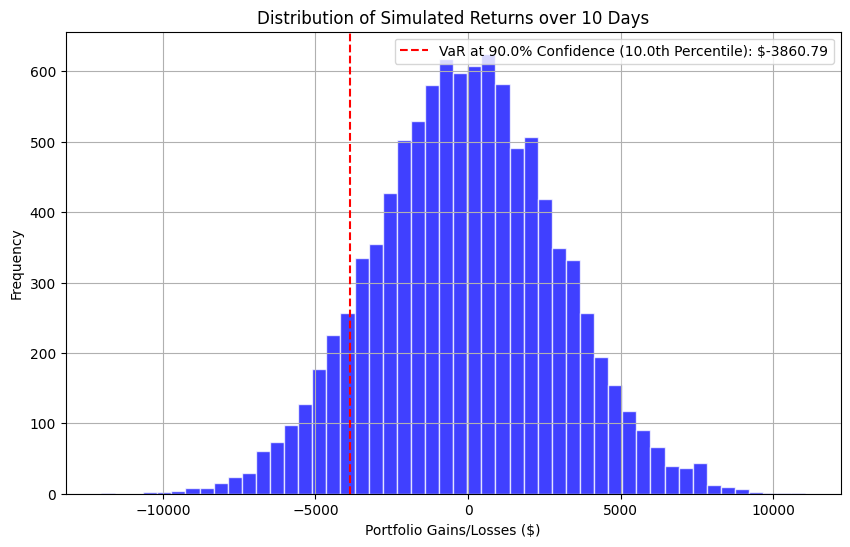

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the period dollar returns at the end of the 10-day period for each simulation
period_dollar_returns = portfolio_values_end_period[:, -1] - initial_investment

# Create the histogram plot using Matplotlib with blue bars and white outlines
plt.figure(figsize=(10, 6))
plt.hist(period_dollar_returns, bins=50, color='blue', edgecolor='white', alpha=0.75)

# Add the VaR line
plt.axvline(x=VaR, color='red', linestyle='--', linewidth=1.5,
            label=f'VaR at {VaR_confidence_level*100}% Confidence ({percentile_level}th Percentile): ${VaR:.2f}')

# Set the plot title and labels
plt.title(f'Distribution of Simulated Returns over {time_period} Days')
plt.xlabel('Portfolio Gains/Losses ($)')
plt.ylabel('Frequency')

# Add a legend
plt.legend()

# Add grid lines
plt.grid(True)

# Show the plot
plt.show()